<a href="https://colab.research.google.com/github/amritavarshini04/Elevate_labs_projects/blob/main/Stock_Price_Trend_Prediction_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installation

In [6]:
pip install yfinance pandas numpy matplotlib scikit-learn tensorflow ta streamlit


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.5 MB/s eta 0:00:00
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=add4f68d5a6f848a28c6c67ac5773db45493a4a3fa978efc080a4302aa6f5f6d
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


Fetch Data using yfinance

In [7]:
import yfinance as yf

ticker = 'AAPL'
df = yf.download(ticker, start='2015-01-01', end='2024-12-31')
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
df.dropna(inplace=True)
df.tail()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Open,High,Low,Close,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2024-12-23,254.156919,255.034791,252.840088,254.655716,40858800
2024-12-24,254.875189,257.588630,254.675658,257.578674,23234700
2024-12-26,257.568678,259.474086,257.010028,258.396667,27237100
2024-12-27,257.209530,258.077462,252.451019,254.974930,42355300
2024-12-30,251.623005,252.889953,250.146571,251.593079,35557500


Feature Engineering
Moving Average & RSI

In [8]:
import ta
import pandas as pd # Import pandas
import numpy as np # Import numpy

# Ensure 'Close' is a pandas Series before passing it
# Initialize the ta indicators
df['MA20'] = df['Close'].rolling(window=20).mean()

# Use RSI from ta library correctly
rsi_indicator = ta.momentum.RSIIndicator(close=df['Close'], window=14)
df['RSI'] = rsi_indicator.rsi()

# Drop rows with any NaN values (from rolling or RSI)
df.dropna(inplace=True)

# Check the result
print(df[['Close', 'MA20', 'RSI']].tail())

ValueError: Data must be 1-dimensional, got ndarray of shape (2515, 1) instead

Normalize and Prepare Data

In [9]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Close']])

# Create sequences
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))


Build LSTM Model

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Train and Validate

In [11]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 0.0171 - val_loss: 7.7968e-04
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0012 - val_loss: 9.7281e-04
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 9.0809e-04 - val_loss: 0.0022
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 8.5022e-04 - val_loss: 0.0011
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 7.1830e-04 - val_loss: 7.5063e-04
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 8.2736e-04 - val_loss: 0.0027
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 8.4823e-04 - val_loss: 0.0012
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 8.3983e-04 - val_loss: 0.0033
Epoch 10/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 8.1856e-04 - val_loss: 0.0026


Plot Predictions vs Actual


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


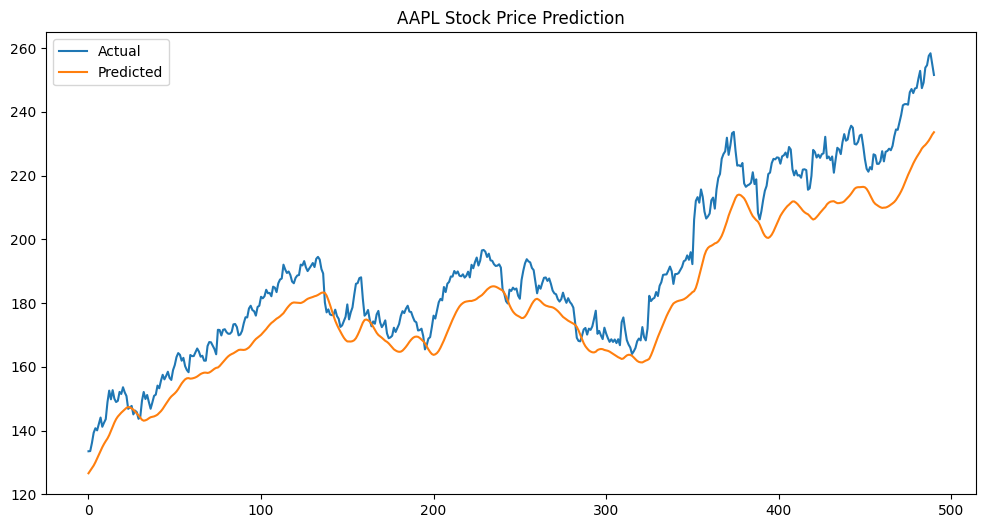

In [14]:
import matplotlib.pyplot as plt

predicted = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual')
plt.plot(predicted_prices, label='Predicted')
plt.title(f'{ticker} Stock Price Prediction')
plt.legend()
plt.show()


Save Model & Weights



In [15]:
model.save('lstm_model.h5')


Streamlit Dashboard (Optional)

In [16]:
import streamlit as st
import yfinance as yf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.preprocessing import MinMaxScaler

st.title("Stock Price Prediction with LSTM")

ticker = st.text_input("Enter Stock Ticker", "AAPL")
data = yf.download(ticker, start='2015-01-01', end='2024-12-31')
st.line_chart(data['Close'])

model = load_model('lstm_model.h5')

# Prepare latest data
scaled = MinMaxScaler().fit_transform(data[['Close']].values)
seq_length = 60
last_seq = scaled[-seq_length:]
last_seq = np.reshape(last_seq, (1, seq_length, 1))

predicted = model.predict(last_seq)
predicted_price = MinMaxScaler().fit(data[['Close']]).inverse_transform(predicted)[0][0]

st.metric(label="Predicted Next Price", value=f"${predicted_price:.2f}")


2025-05-17 07:45:18.286 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-17 07:45:18.418 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-05-17 07:45:18.419 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-17 07:45:18.421 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-17 07:45:18.422 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-17 07:45:18.424 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-17 07:45:18.425 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-17 07:45:18.426 Session state does not 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


2025-05-17 07:45:19.440 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-17 07:45:19.441 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()